# Transfer learning

In this tutorial you'll learn to use a pre trained model to classify objects in images. The input image can be of any size. Hopefully you will also get some understanding in how a model labels an image.

This notebook is inspired by the following [blog post](https://www.learnopencv.com/fully-convolutional-image-classification-on-arbitrary-sized-image/).


by Odd Eirik Igland

## Imports

In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, hub
from torchvision import models, transforms

%matplotlib inline

## Properties of natural signals

- *Locality*: things that are close are often equal
- *Stationarity*: same pattern can be found several places in data
- *Compositionality*: a complex expression is determined by its existing expressions and the combination between them


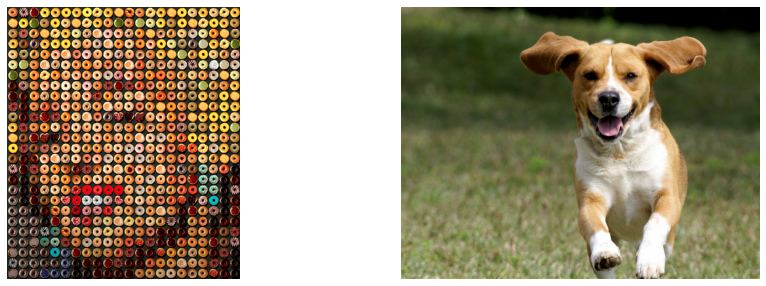

In [2]:
compositionality = cv2.imread("data/compositionality.png")
dog = cv2.imread("data/dog.jpeg")
rgb_image_1 = cv2.cvtColor(compositionality, cv2.COLOR_BGR2RGB)
rgb_image_2 = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(rgb_image_1);
ax[1].imshow(rgb_image_2);

Image sources: [Marilyn Monroe](https://youtu.be/kwPWpVverkw?t=748), [dog](https://i.insider.com/5484d9d1eab8ea3017b17e29?width=1100&format=jpeg&auto=webp)

## Interactive Node-Link Visualization of:

### [Fully Connected Neural Networks](https://www.cs.ryerson.ca/~aharley/vis/fc/)

### [Convolutional Neural Networks](https://www.cs.ryerson.ca/~aharley/vis/conv/)

## ResNet 18
Image source: [resnet](https://i.imgur.com/XwcnU5x.png)

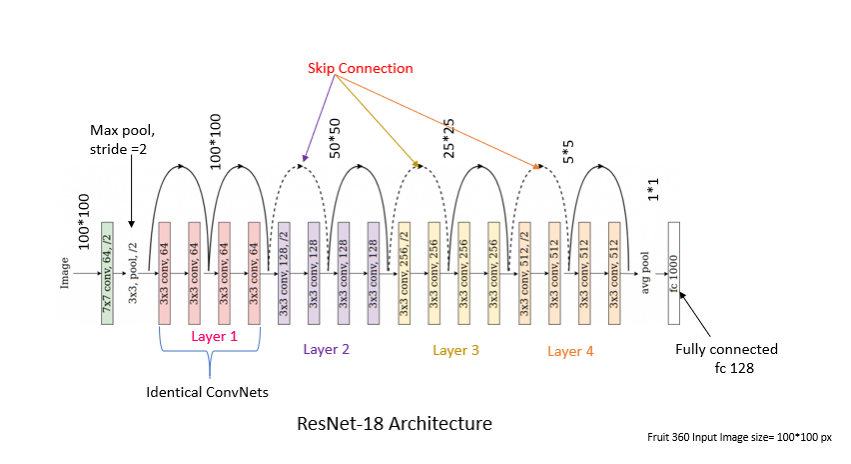

In [3]:
original_image = cv2.imread("data/resnet18.png")
rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (15,10))
plt.axis('off')
plt.imshow(rgb_image);

## Define and instanciate the model

The model below is based on the ResNet-18 model. The expected input size for the network is 224×224. We will customize it to use a convolutional layer instead of a fully-connected layer in the end to handle any image input size.

By setting the pretrained variable to true the network weights will be downloaded.

In [4]:
class CustomResNet(models.ResNet):
    def __init__(self, num_classes=1000, pretrained=False, **kwargs):
        super().__init__(
            block=models.resnet.BasicBlock,
            layers=[2, 2, 2, 2],
            num_classes=num_classes,
            **kwargs
        )
        if pretrained:
            state_dict = hub.load_state_dict_from_url(
                models.resnet.model_urls["resnet18"], progress=True
            )
            self.load_state_dict(state_dict)

        # changes the original resnet architecture to not use fc layers
        self.avgpool = nn.AvgPool2d((7, 7))

        self.last_conv = nn.Conv2d(
            in_channels=self.fc.in_features, out_channels=num_classes, kernel_size=1
        )

        # copying weights and bias from the fc layer
        self.last_conv.weight.data.copy_(
            self.fc.weight.data.view(*self.fc.weight.data.shape, 1, 1)
        )
        self.last_conv.bias.data.copy_(self.fc.bias.data)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)

        # Uses conv layer instead of FC, which is used in the original ResNet
        x = self.last_conv(x)
        return x

model = CustomResNet(pretrained=True).eval()

## Model labels
The ResNet network is trained on a data set called imagenet. This is a data set with more than 14 million images. All this images are labeled into 1000 clases. The labels can be found in [*imagenet_classes.txt*](https://raw.githubusercontent.com/spmallick/learnopencv/master/PyTorch-Fully-Convolutional-Image-Classification/imagenet_classes.txt).

The imagenet file is opened in the cell below. **How do we put the values in the variable called labels?**

<details><summary>Hint 1</summary>
<p>

Search string: *read text file python to list per line*

</p>
</details>

<details><summary>Hint 2</summary>
<p>

```python
[line.strip() for line in f.readlines()]
```

</p>
</details>

In [5]:
with open("data/imagenet_classes.txt") as f:
    labels = [line.strip() for line in f.readlines()]
labels[:5]

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark']

## Load image
This pretrained model can take any image as input. Add more images to the *images* folder, and add the filename in the list below to classify its content. Image sources: [hare](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fi.ytimg.com%2Fvi%2FrWTV4axEgYw%2Fmaxresdefault.jpg&f=1&nofb=1), [dog](https://res.cloudinary.com/dktx1oojk/image/upload/f_auto,q_90,w_1000,c_scale/web/globalassets/group/breed-tool/images-dogs/siberian_husky.jpg), [gorilla](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fs28164.pcdn.co%2Ffiles%2FWestern-Lowland-Gorilla-0088-8441-1280x720.jpg&f=1&nofb=1)

**Create the relative path for an image.**
<details><summary>Hint 1</summary>
<p>

The images are saved in a folder called *images*

</p>
</details>

<details><summary>Hint 2</summary>
<p>

```python
f"images/{images[2]}"
```

</p>
</details>

In [6]:
images = ["hare.jpeg", "secret_doggy.jpeg", "gorilla.jpeg"]
IMAGE_PATH = f"images/{images[2]}"

(720, 1280, 3)


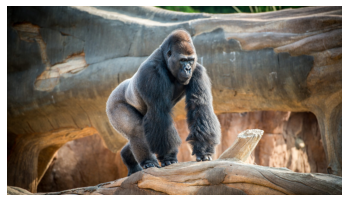

In [7]:
original_image = cv2.imread(IMAGE_PATH)
print(original_image.shape)
rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(rgb_image);

## Transform image
The image is converted to a tensor. The tensor have three channels(red, green and blue), where each of them hold the brightness of their color. This value is in range of 0 to 1. Further the value is normalized based on the mean of all the images in the imagenet data set. Unsqueeze is used to turn the input into expected dimension for the model.

**Find the mean and standard deviation for the imagenet data set.**
<details><summary>Hint 1</summary>
<p>

Search string: *mean std imagenet*

</p>
</details>

<details><summary>Hint 2</summary>
<p>

```python
mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
```

</p>
</details>

In [8]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
    
image = transform(rgb_image)
print(image.shape)
image = image.unsqueeze(0)
print(image.shape)

torch.Size([3, 720, 1280])
torch.Size([1, 3, 720, 1280])


Setting set_grad_enable to false to perform inference without Gradient Calculation. Since we're not going to train our model we do not need to update any weight or biases. As well we do not want to leak test data into the model.

In [9]:
torch.set_grad_enabled(False);

## Predict image class
Send our image through the network. Look at the output shape.

**Why is one of the dimensions 1000?**

In [10]:
predicates = model(image)
predicates.shape

torch.Size([1, 1000, 3, 5])

Finding the classes with highest activation in each of the output cells.

In [11]:
predicates = torch.softmax(predicates, dim=1)

**Find the k best predicated classes.**
<details><summary>Hint 1</summary>
<p>
    
[Link](https://stackoverflow.com/a/55802422/11079413)

</p>
</details>

<details><summary>Hint 2</summary>
<p>

```python
predicates.topk(NUMBER_OF_TOP_PREDICTIONS, dim=1)
```

</p>
</details>

In [12]:
NUMBER_OF_TOP_PREDICTIONS = 3
preds, class_idexes = predicates.topk(NUMBER_OF_TOP_PREDICTIONS, dim=1)
preds, class_idexes

(tensor([[[[0.5253, 0.0338, 0.4925, 0.2700, 0.0518],
           [0.4906, 0.0624, 0.8859, 0.5691, 0.0177],
           [0.0312, 0.0940, 0.0861, 0.2744, 0.0640]],
 
          [[0.0999, 0.0292, 0.0608, 0.0756, 0.0494],
           [0.1144, 0.0599, 0.0502, 0.0885, 0.0133],
           [0.0266, 0.0681, 0.0769, 0.0993, 0.0634]],
 
          [[0.0361, 0.0235, 0.0508, 0.0495, 0.0405],
           [0.0257, 0.0282, 0.0204, 0.0713, 0.0128],
           [0.0235, 0.0667, 0.0720, 0.0892, 0.0576]]]]),
 tensor([[[[297, 469, 366, 366, 666],
           [297, 383, 366, 366, 297],
           [297, 297, 104, 297, 367]],
 
          [[367, 463, 367, 387, 596],
           [367, 286, 367, 372, 377],
           [ 61, 367, 368, 379, 366]],
 
          [[295, 666, 294, 379,  96],
           [ 48, 279, 365, 368, 387],
           [ 48, 366, 366, 368,  43]]]]))

The output cell with the highest probability holds the class the network is most certain of.

**Fix the prediction print.**
<details><summary>Hint 1</summary>
<p>
    
What did you store in the variable *labels*? Which of the variables in the for loop have the certainty?

</p>
</details>

<details><summary>Hint 2</summary>
<p>

```python
print(f"Predicted Class: {labels[predicted_class]} with {round(float(col_max[0]),3)*100}% certainty")
```

</p>
</details>

In [13]:
for i in range(NUMBER_OF_TOP_PREDICTIONS-1,-1,-1):
    pred = preds[:,i]
    class_index = class_idexes[:,i]
    row_max, row_idx = torch.max(pred, dim=1)
    col_max, col_idx = torch.max(row_max, dim=1)
    predicted_class = class_index[0, row_idx[0, col_idx], col_idx]
    print(f"Predicted Class: {labels[predicted_class]} with {round(float(col_max[0]),3)*100}% certainty")

Predicted Class: gibbon, Hylobates lar with 8.9% certainty
Predicted Class: chimpanzee, chimp, Pan troglodytes with 11.4% certainty
Predicted Class: gorilla, Gorilla gorilla with 88.6% certainty


## Create the receptive field
The score map shows the probability of the predicted class in each of the output cells.

In [14]:
score_map = predicates[0, predicted_class, :, :].numpy()
score_map = score_map[0]
print(score_map.shape)
score_map

(3, 5)


array([[0.03396521, 0.00328953, 0.4925447 , 0.27001888, 0.00226564],
       [0.02301385, 0.02365073, 0.8859098 , 0.569113  , 0.00511801],
       [0.00662131, 0.06674388, 0.07202214, 0.0473124 , 0.06342596]],
      dtype=float32)

Scaling the output cells to the original image cells makes it possible to find where the prediction actually was.

**Give the score map same size as the original image.**
<details><summary>Hint 1</summary>
<p>

```python
cv2.resize(target, (width, height))   
```


</p>
</details>

<details><summary>Hint 2</summary>
<p>

```python
score_map = cv2.resize(score_map, (original_image.shape[1], original_image.shape[0]))  
```

</p>
</details>

In [15]:
score_map = cv2.resize(score_map, (original_image.shape[1], original_image.shape[0]))
print(original_image.shape)
print(score_map.shape)

(720, 1280, 3)
(720, 1280)


## Binarize the score map

In [16]:
_, score_map_for_contours = cv2.threshold(
    score_map, 0.25, 1, type=cv2.THRESH_BINARY
)
score_map_for_contours = score_map_for_contours.astype(np.uint8).copy()

## Create a bounding box
Find the contour, representation or bounding the shape or form of something, from the binary score map. This contour is used to create a bounding box around the object.

**Use the contours to create one bounding box.**
<details><summary>Hint 1</summary>
<p>

[Example](https://www.programcreek.com/python/example/89437/cv2.boundingRect).

</p>
</details>

<details><summary>Hint 2</summary>
<p>

```python
cv2.boundingRect(contours[0])
```

</p>
</details>

In [17]:
contours, _ = cv2.findContours(
    score_map_for_contours,
    mode=cv2.RETR_EXTERNAL,
    method=cv2.CHAIN_APPROX_SIMPLE,
)
rect = cv2.boundingRect(contours[0])

Using the score map to create a mask on the original image

In [18]:
score_map = score_map - np.min(score_map[:])
score_map = score_map / np.max(score_map[:])
score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2BGR)

Joining the score map with the original image and applying the bounding box.

In [19]:
masked_image = (rgb_image * score_map).astype(np.uint8)
cv2.rectangle(
    masked_image,
    rect[:2],
    (rect[0] + rect[2], rect[1] + rect[3]),
    (255, 0, 0),
    2,
);

## Compare the generated images with the original

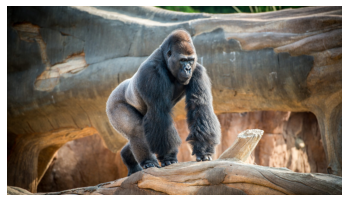

In [20]:
plt.axis('off')
plt.imshow(rgb_image);

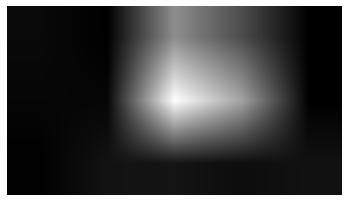

In [21]:
plt.axis('off')
plt.imshow(score_map);

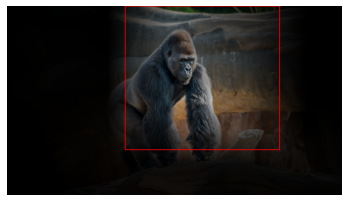

In [22]:
plt.axis('off')
plt.imshow(masked_image);

## Further work

- Check that this model works with a random image.
- Make the model predict more than one object in an image.
- Experiment with another pre trained model.
- Create a better receptive field, check out this [blog post](https://www.learnopencv.com/cnn-receptive-field-computation-using-backprop/)